In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

In [109]:
# 
train_data = pd.read_csv("training_loan_data.csv", header=1, low_memory=False)
# Preview the DataFrame to ensure the second row was used as the header
# Step 1: Explore and Inspect Data
print("Training Data Info:")
print(train_data.info())
print("Missing Values in Training Data:")
print(train_data.isnull().sum())

# Target variable: 'bad_flag'
print("Target Distribution:")
print(train_data['bad_flag'].value_counts())

test_data = pd.read_csv("testing_loan_data.csv", header=0, low_memory=False)
print(test_data.info())

# Step 0: Drop rows where 'bad_flag' is missing in the training data
train_data.dropna(subset=['bad_flag'], inplace=True)
print(f"Rows remaining in training data after dropping missing 'bad_flag': {len(train_data)}")

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199121 entries, 0 to 199120
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           199121 non-null  int64  
 1   member_id                    189457 non-null  float64
 2   loan_amnt                    199121 non-null  int64  
 3   term                         189457 non-null  object 
 4   int_rate                     189457 non-null  object 
 5   emp_length                   181531 non-null  object 
 6   home_ownership               189457 non-null  object 
 7   annual_inc                   189457 non-null  float64
 8   desc                         82004 non-null   object 
 9   purpose                      189457 non-null  object 
 10  percent_bc_gt_75             180419 non-null  float64
 11  bc_util                      180333 non-null  float64
 12  dti                          189457 no

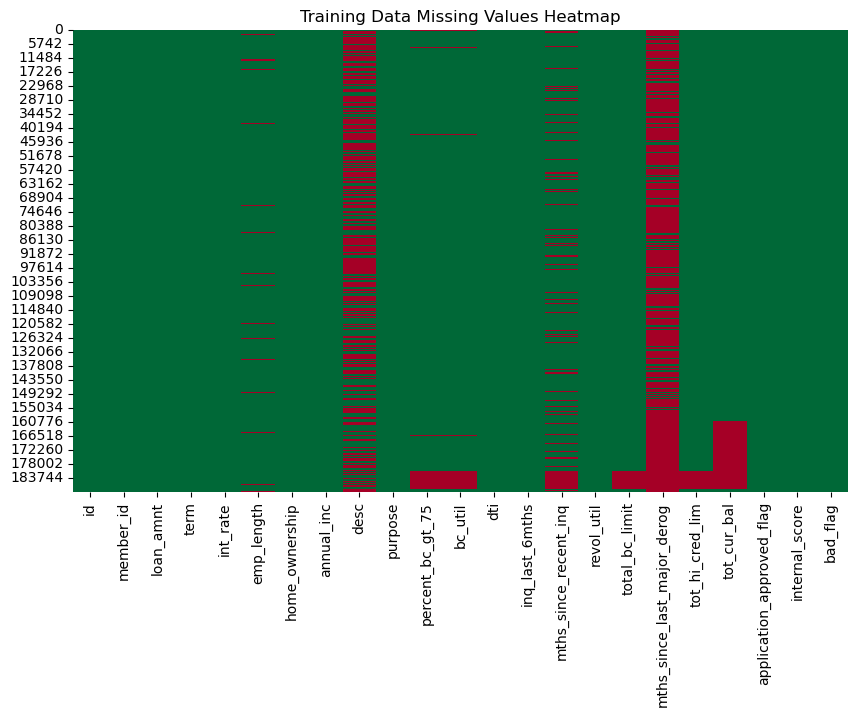

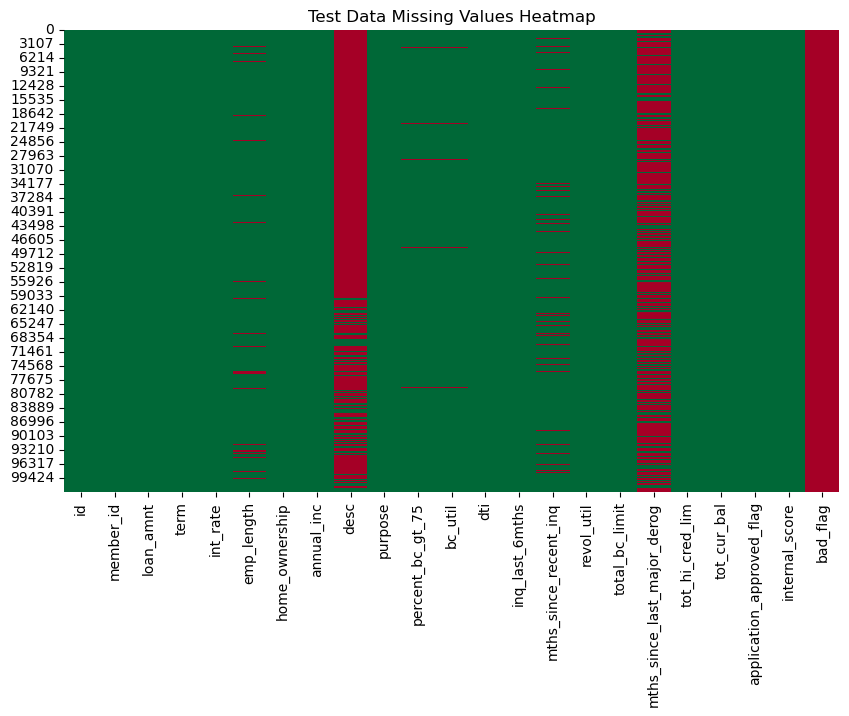

In [110]:
# Training Data  Missing values heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='RdYlGn_r')
plt.title('Training Data Missing Values Heatmap')
plt.show()

# Missing values heatmap
plt.figure(figsize=(10,6))
sns.heatmap(test_data.isnull(), cbar=False,cmap='RdYlGn_r')
plt.title('Test Data Missing Values Heatmap')
plt.show()



In [111]:
# Code to Handle Categorical and Numeric Missing Values

# Step 1: Drop columns with high missing percentage or irrelevant
drop_columns = ['id', 'member_id', 'desc', 'mths_since_last_major_derog']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Step 2: Handle Missing Values

# Impute 'mths_since_recent_inq' missing values with -1
train_data['mths_since_recent_inq'].fillna(-1, inplace=True)
test_data['mths_since_recent_inq'].fillna(-1, inplace=True)
# Remove ' years' and ' months' convert to numeric in 'emp_length' and 'term'
train_data['emp_length'] = train_data['emp_length'].replace({
    '10+ years': '10',
    '< 1 year': '0',
    'unknown': np.nan  # If unknown was filled earlier
})
train_data['emp_length'] = train_data['emp_length'].str.replace(' years', '', regex=False)
train_data['emp_length'] = pd.to_numeric(train_data['emp_length'], errors='coerce')
test_data['emp_length'] = test_data['emp_length'].replace({
    '10+ years': '10',
    '< 1 year': '0',
    'unknown': np.nan  # If unknown was filled earlier
})
test_data['emp_length'] = test_data['emp_length'].str.replace(' years', '', regex=False)
test_data['emp_length'] = pd.to_numeric(test_data['emp_length'], errors='coerce')

train_data['term'] = train_data['term'].str.strip()
train_data['term'] = train_data['term'].str.replace(' months', '', regex=False)
train_data['term'] = pd.to_numeric(train_data['term'], errors='coerce')
test_data['term'] = test_data['term'].str.strip()
test_data['term'] = test_data['term'].str.replace(' months', '', regex=False)
test_data['term'] = pd.to_numeric(test_data['term'], errors='coerce')

# Fill missing numerical columns with the median
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)
    
# Convert percentage columns to numeric
percentage_cols = ['int_rate', 'revol_util']
for col in percentage_cols:
    train_data[col] = train_data[col].str.rstrip('%').astype('float') / 100
    test_data[col] = test_data[col].str.rstrip('%').astype('float') / 100
        
    # Keep only 4 decimal places
    train_data[col] = train_data[col].apply(lambda x: round(x, 4))
    test_data[col] = test_data[col].apply(lambda x: round(x, 4))
    # Fill missing values after conversion
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Fill missing categorical columns with 'unknown'
categorical_cols = train_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    train_data[col].fillna('unknown', inplace=True)
    test_data[col].fillna('unknown', inplace=True)
   
# Step 3: Verify Missing Values Are Handled
print("Remaining Missing Values in Train Data:\n", train_data.isnull().sum())
print("Remaining Missing Values in Test Data:\n", test_data.isnull().sum())
print("Training Data Info:")
print(train_data.info())
# Step 5: Save Cleaned Data (optional)
train_data.to_csv("cleaned_training_dataset.csv", index=False)
test_data.to_csv("cleaned_testing_dataset.csv", index=False)


Remaining Missing Values in Train Data:
 loan_amnt                    0
term                         0
int_rate                     0
emp_length                   0
home_ownership               0
annual_inc                   0
purpose                      0
percent_bc_gt_75             0
bc_util                      0
dti                          0
inq_last_6mths               0
mths_since_recent_inq        0
revol_util                   0
total_bc_limit               0
tot_hi_cred_lim              0
tot_cur_bal                  0
application_approved_flag    0
internal_score               0
bad_flag                     0
dtype: int64
Remaining Missing Values in Test Data:
 loan_amnt                         0
term                              0
int_rate                          0
emp_length                        0
home_ownership                    0
annual_inc                        0
purpose                           0
percent_bc_gt_75                  0
bc_util                      

/var/folders/mx/dpb33fgj40s2zzfsx4rmn98c0000gn/T/ipykernel_54758/479215240.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train_data.corr()


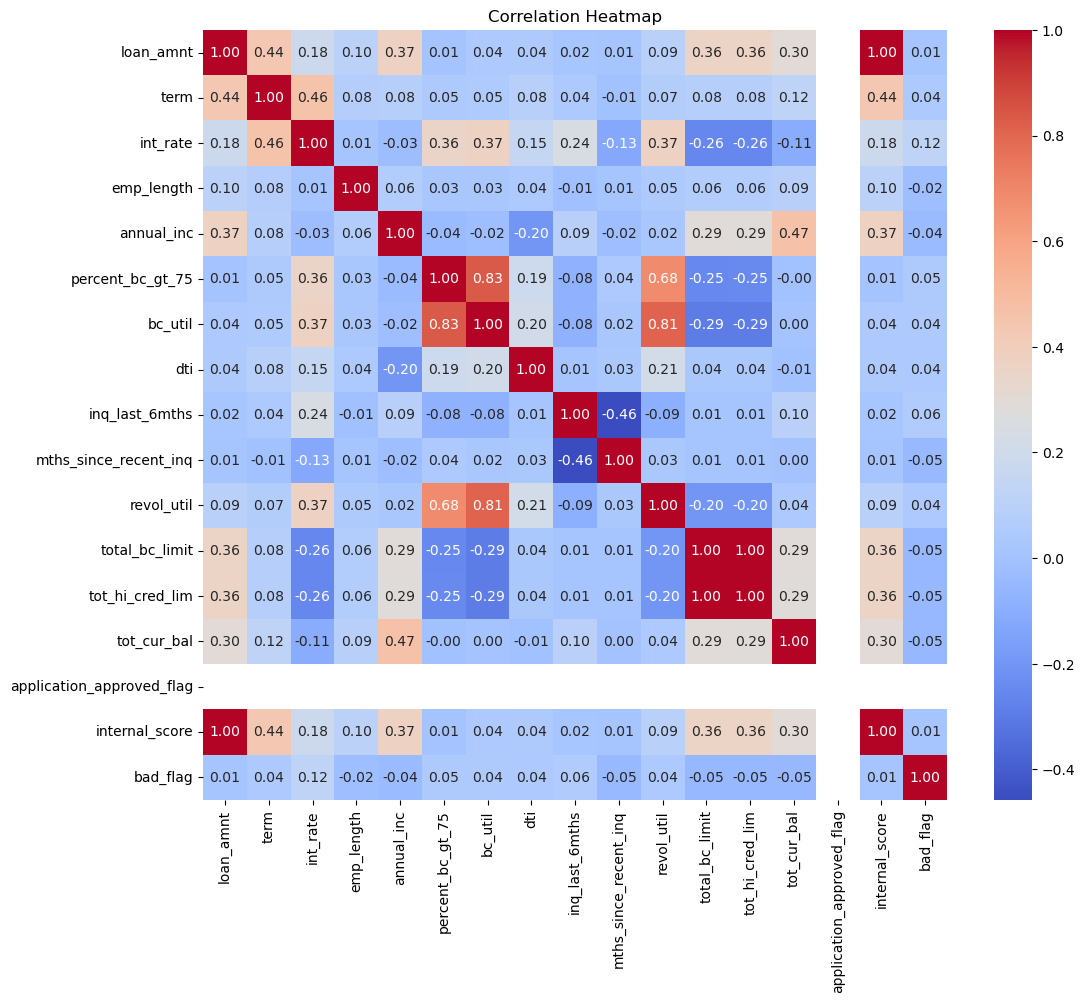

In [113]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = train_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


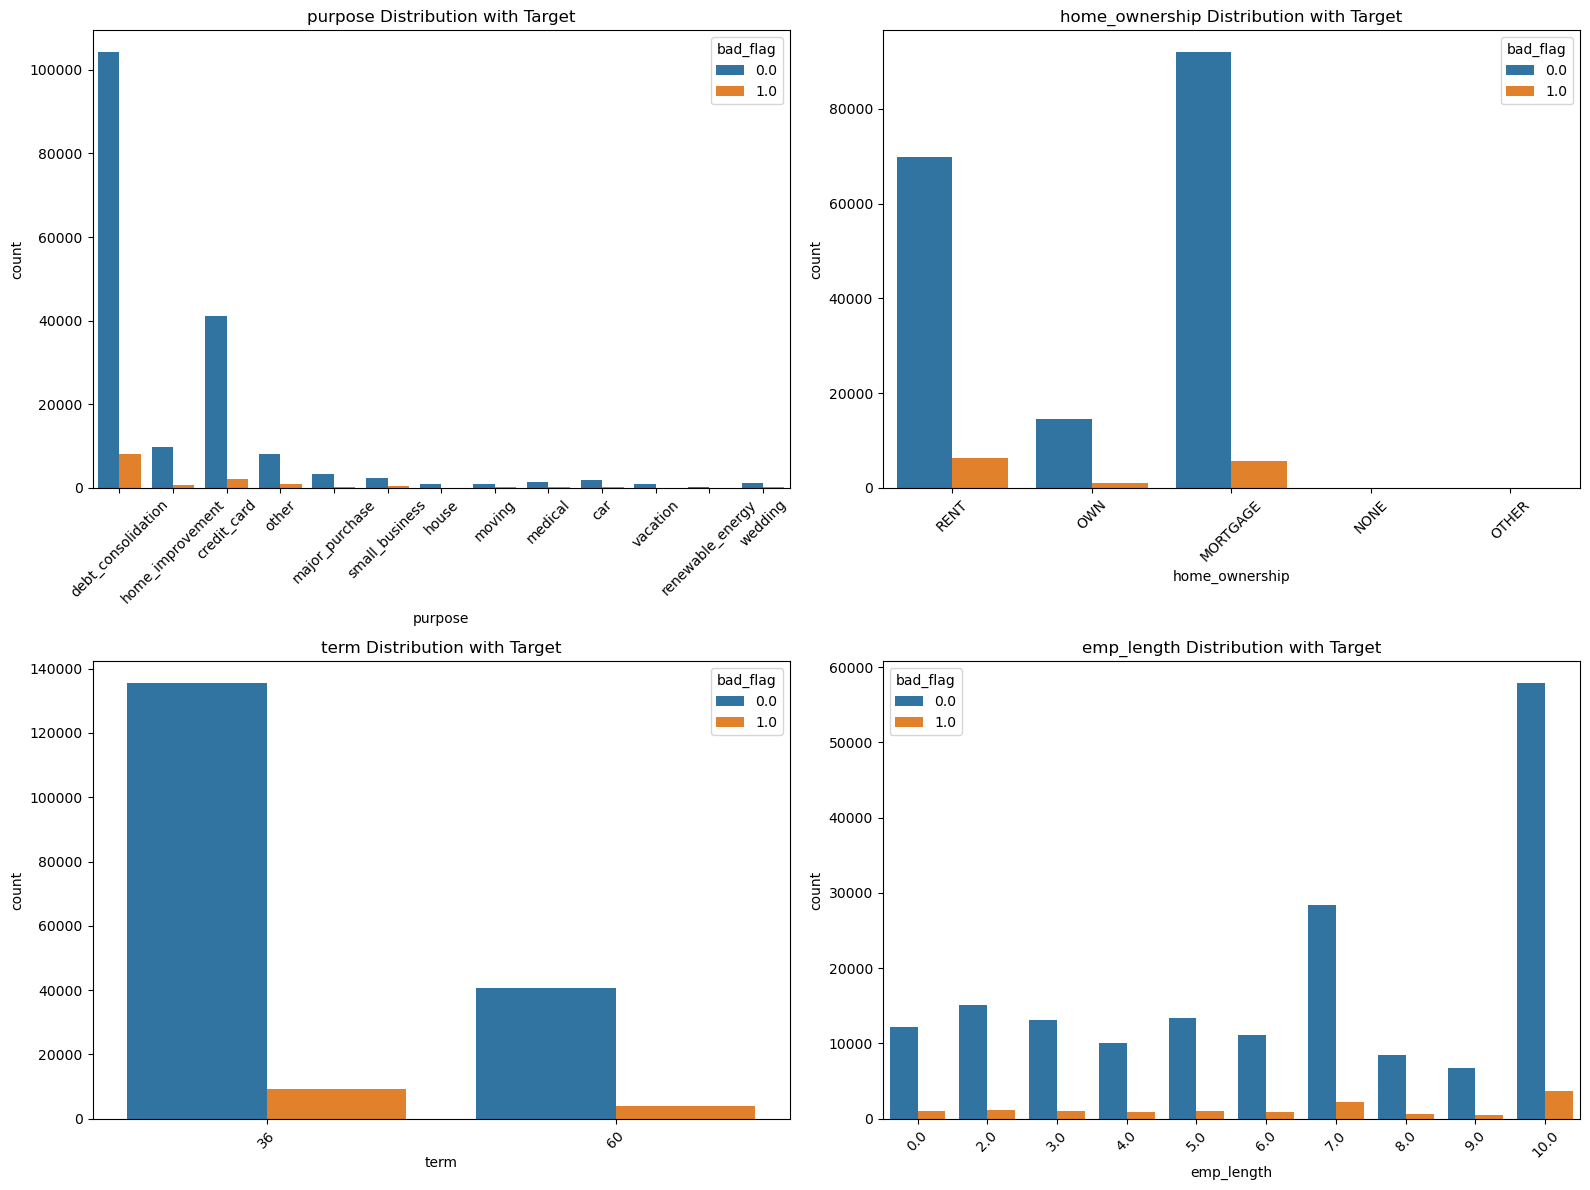

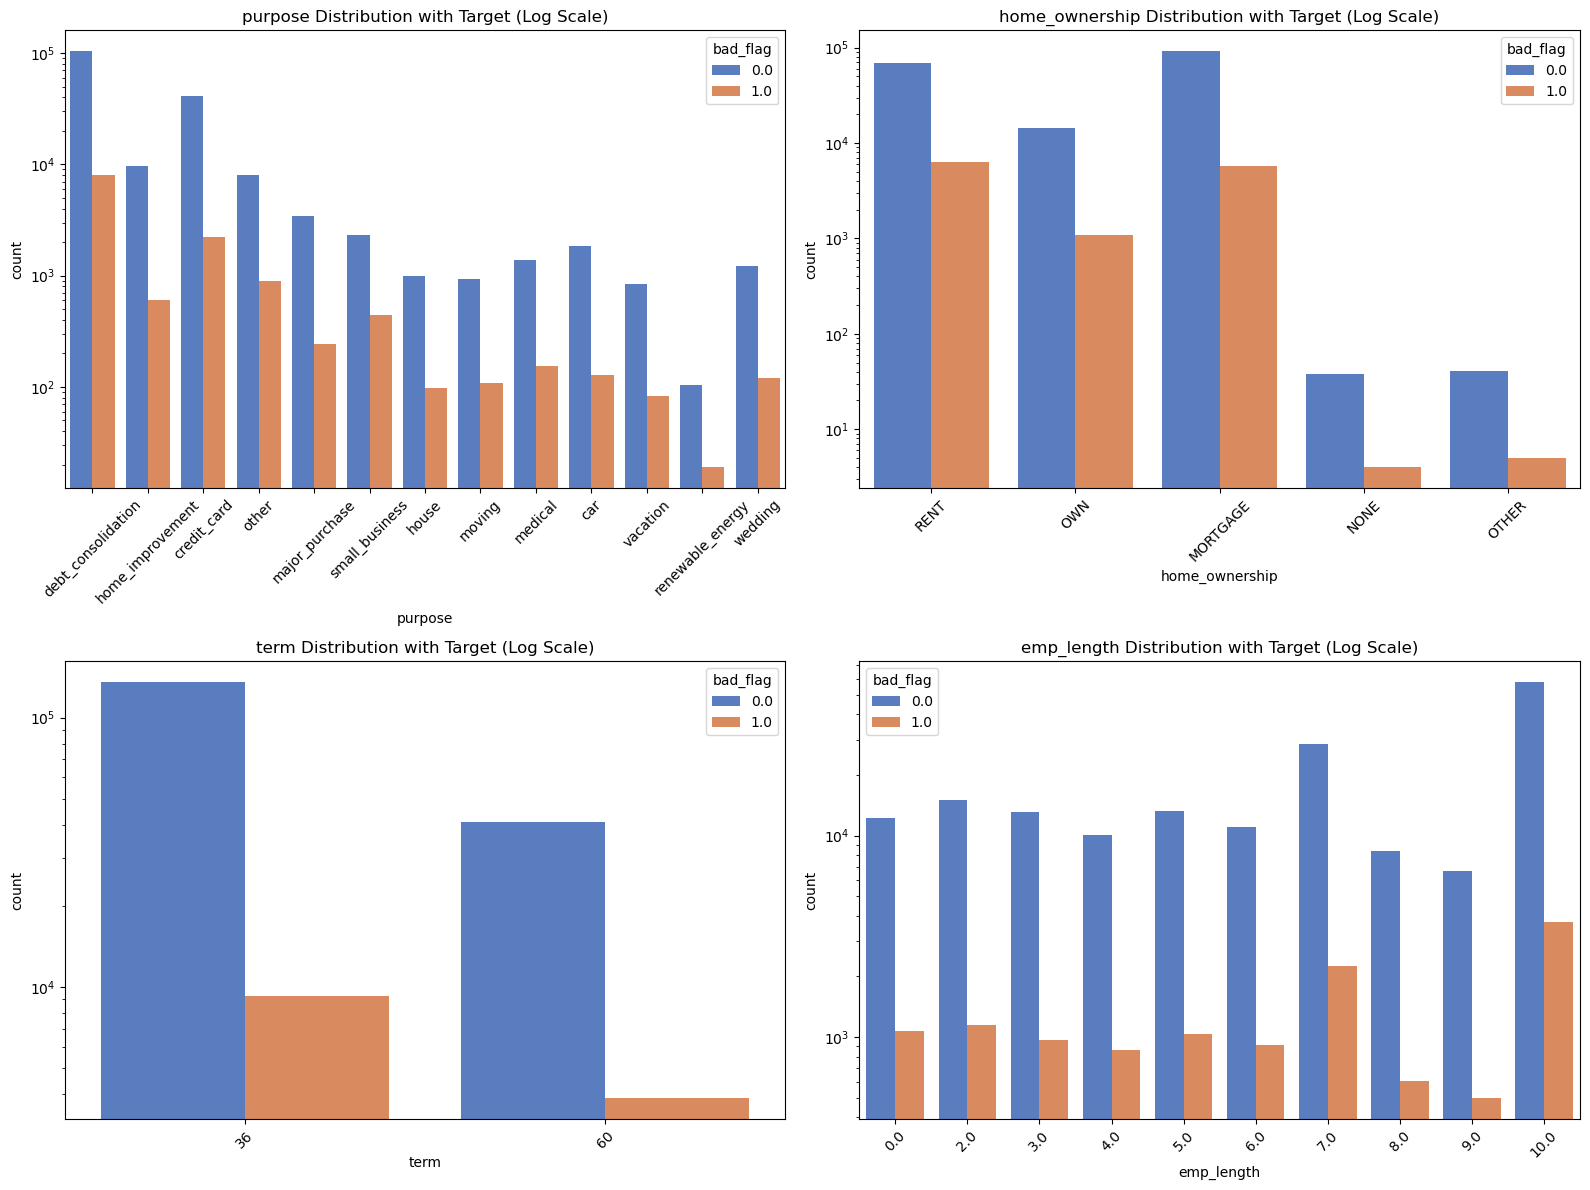

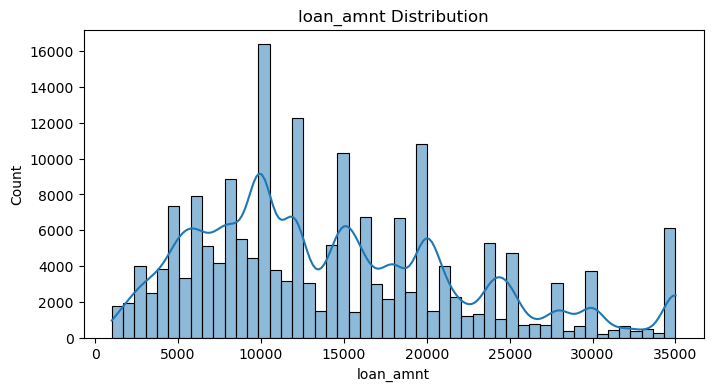

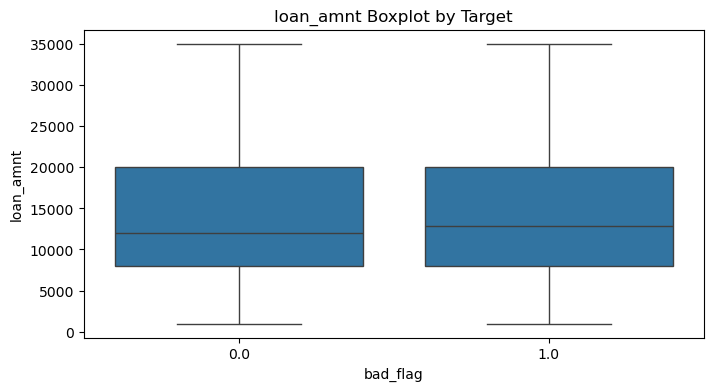

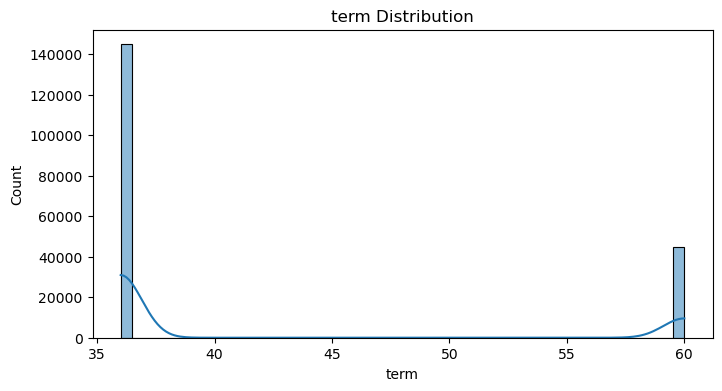

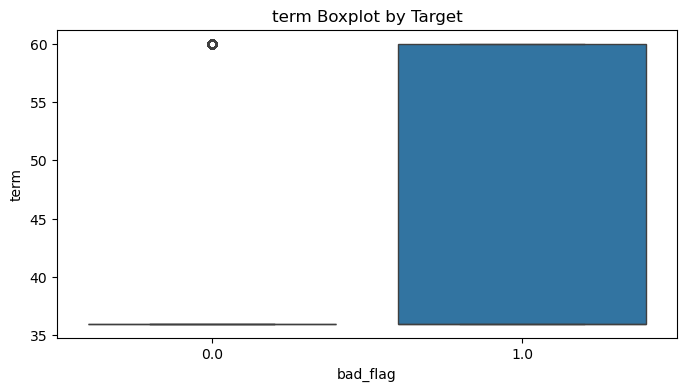

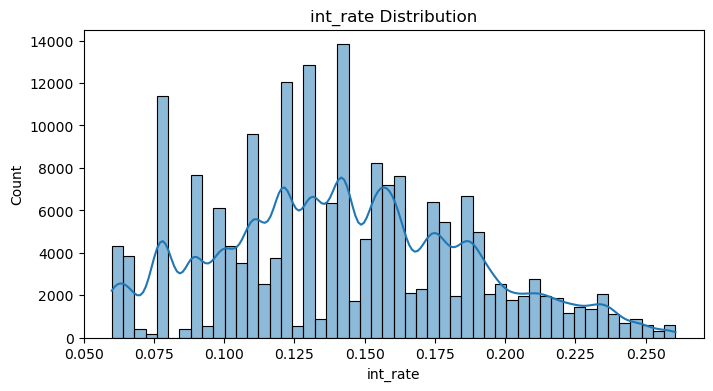

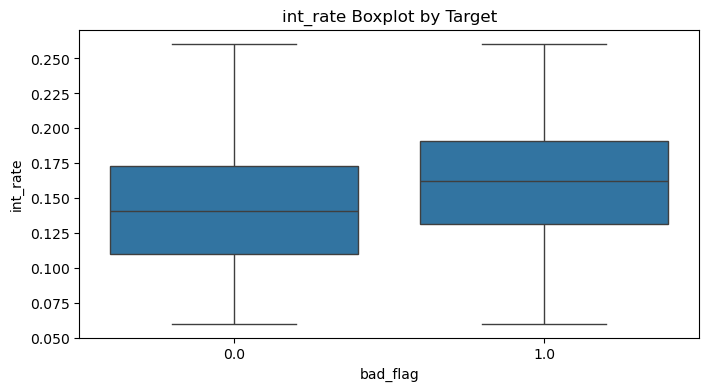

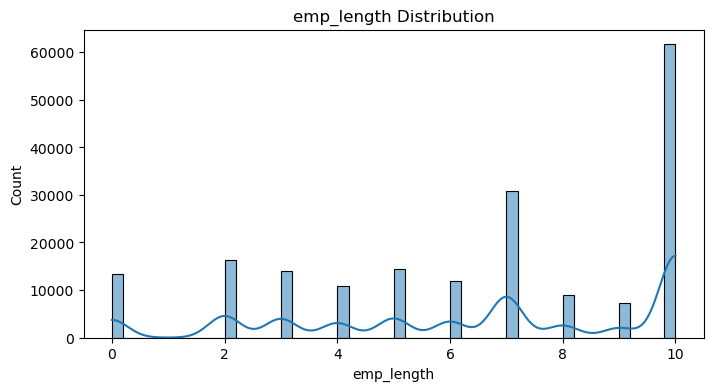

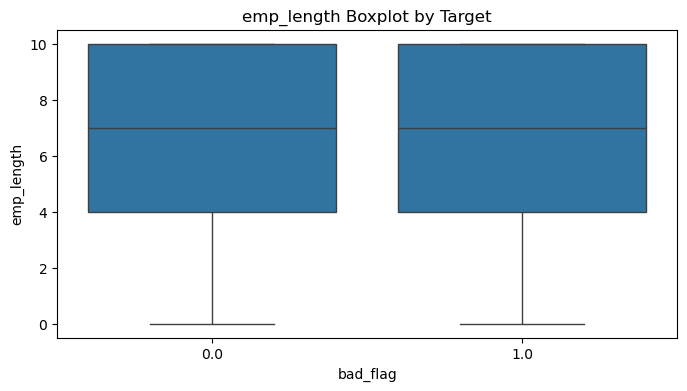

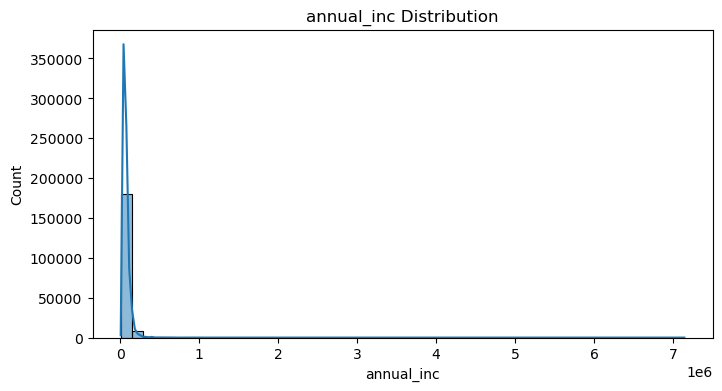

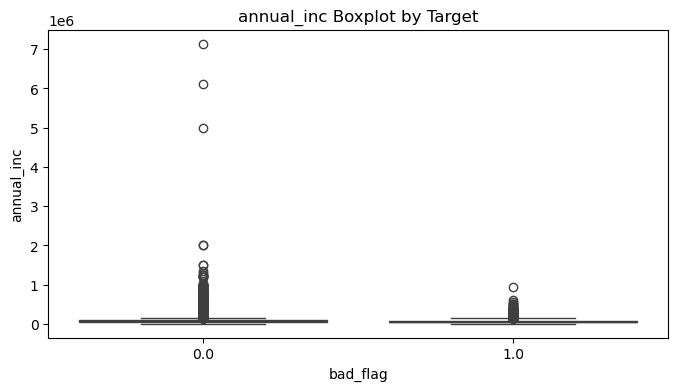

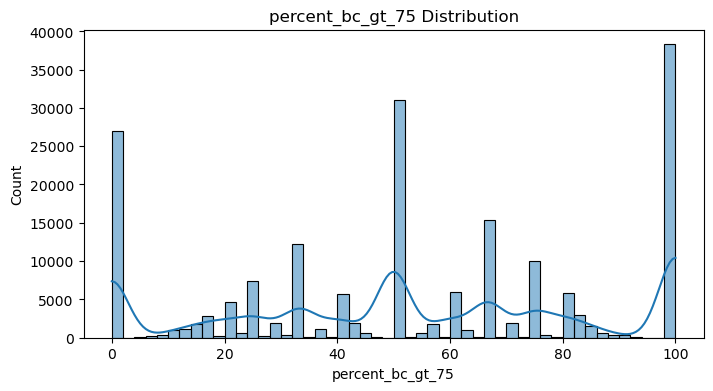

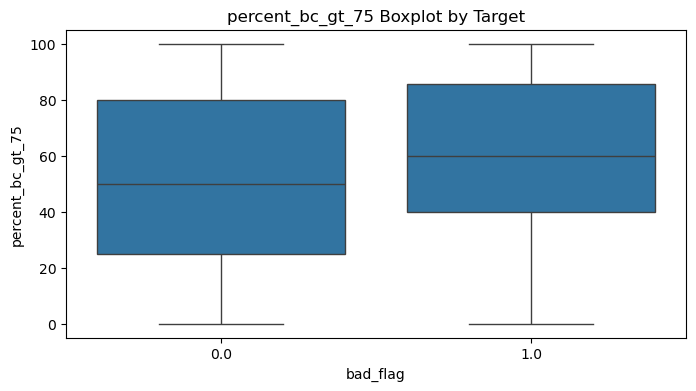

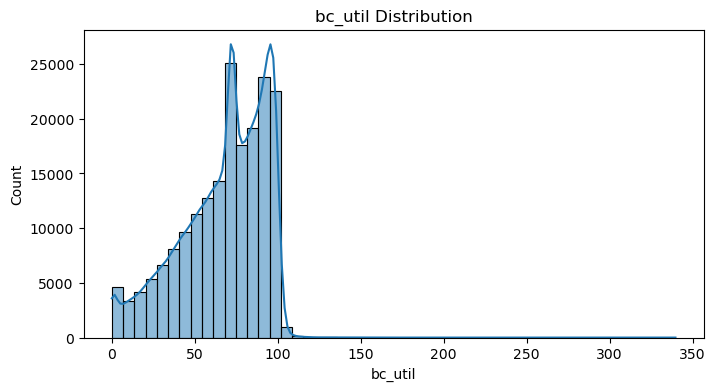

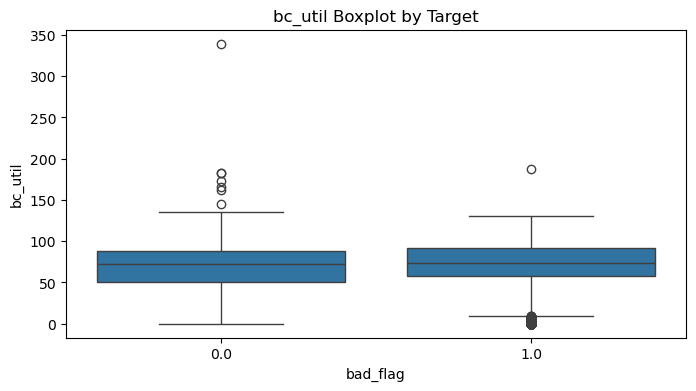

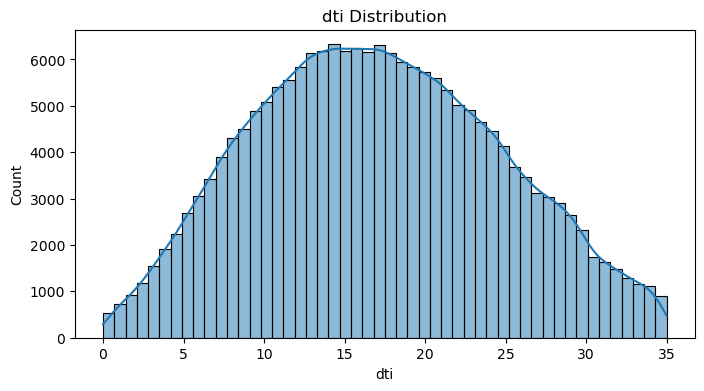

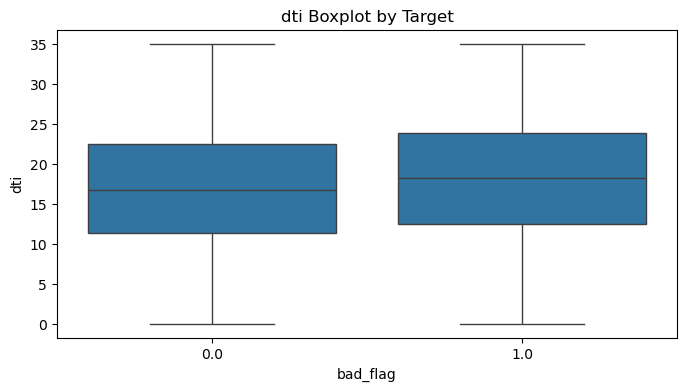

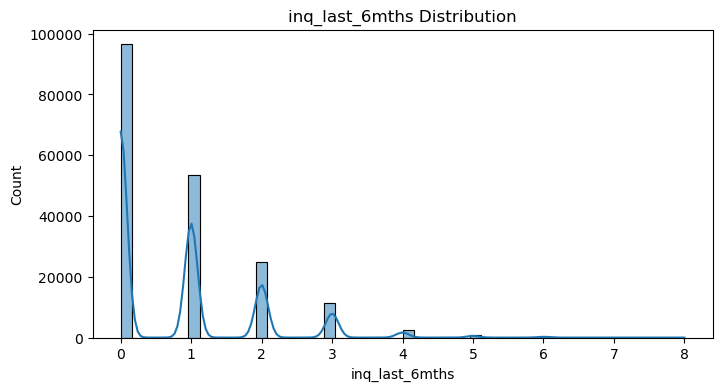

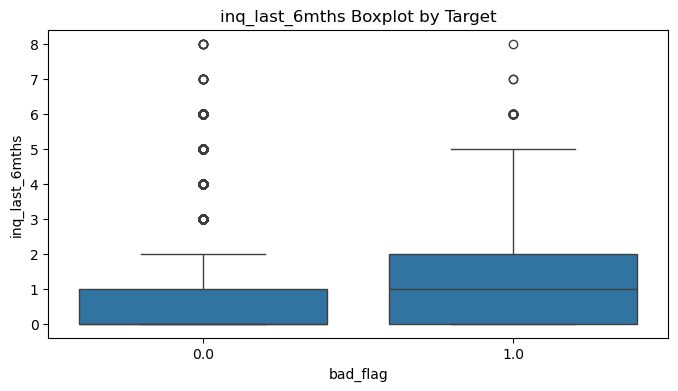

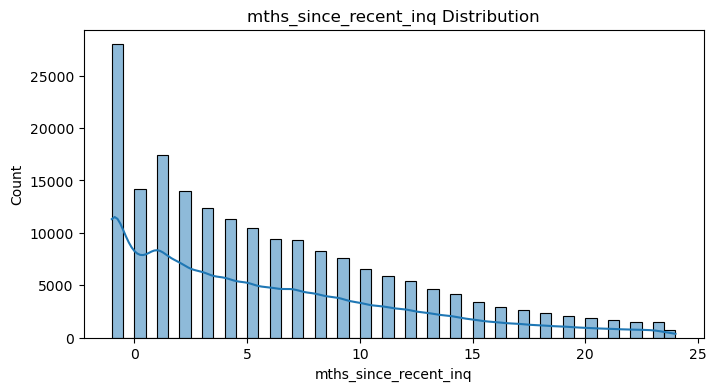

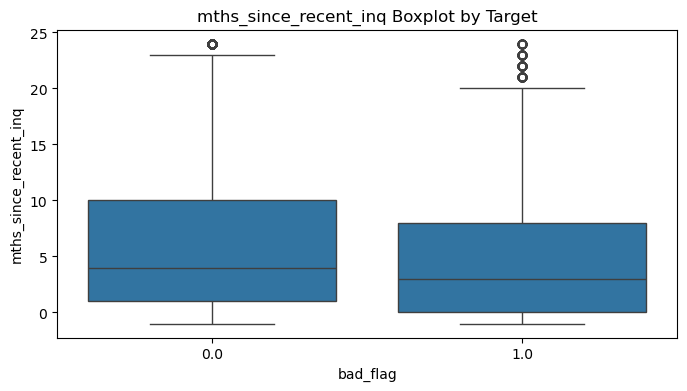

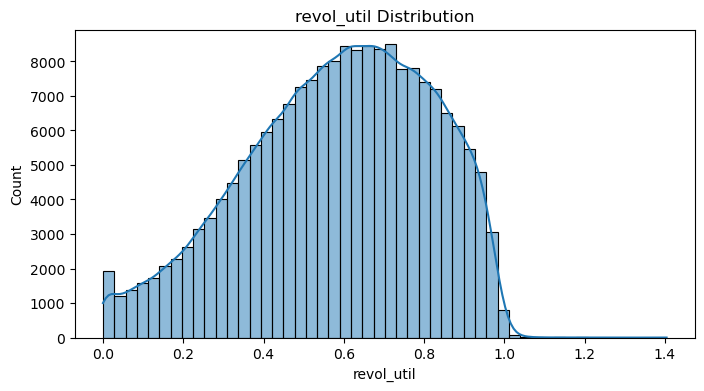

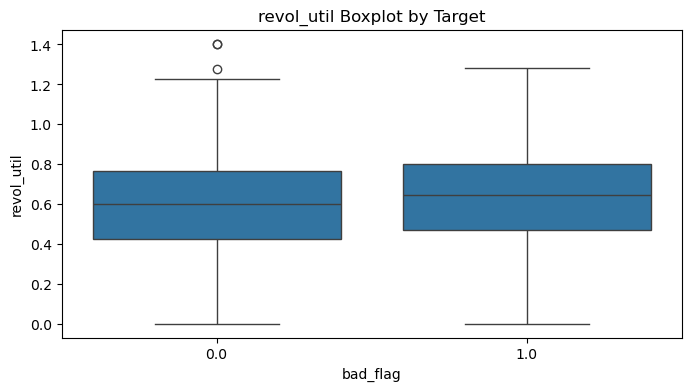

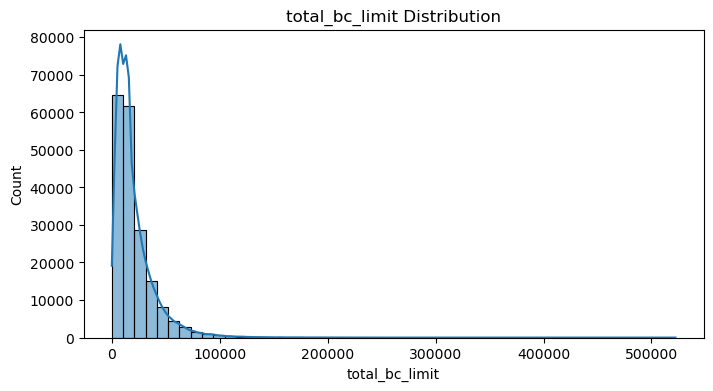

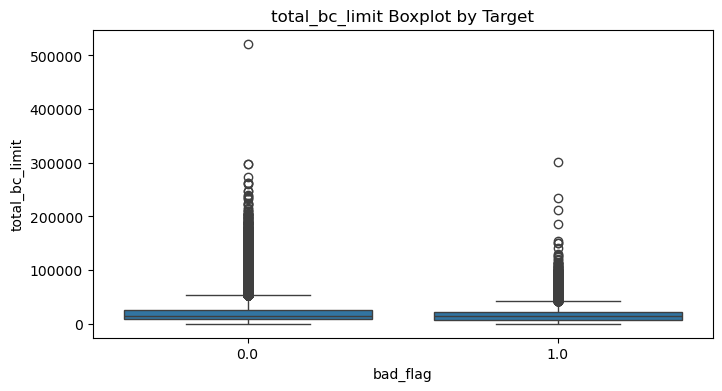

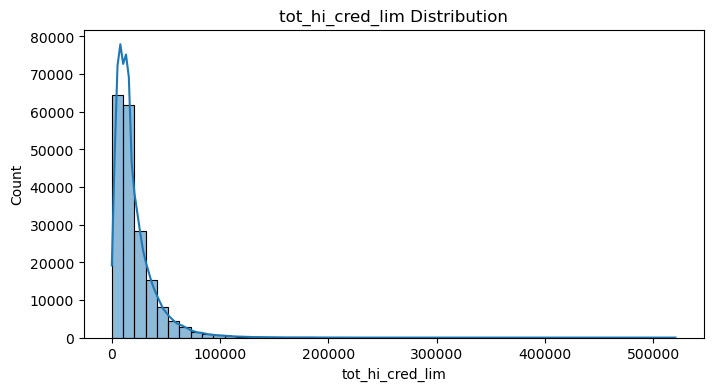

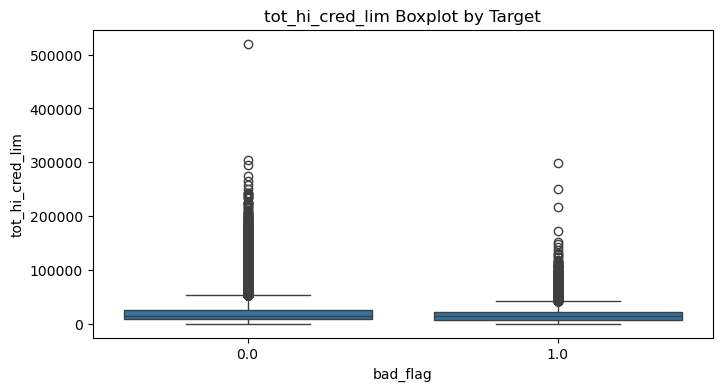

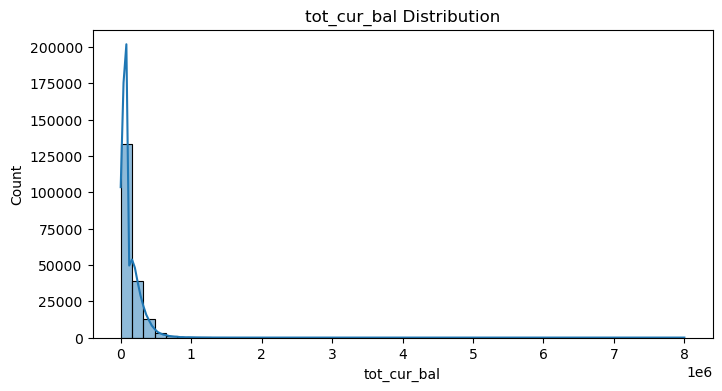

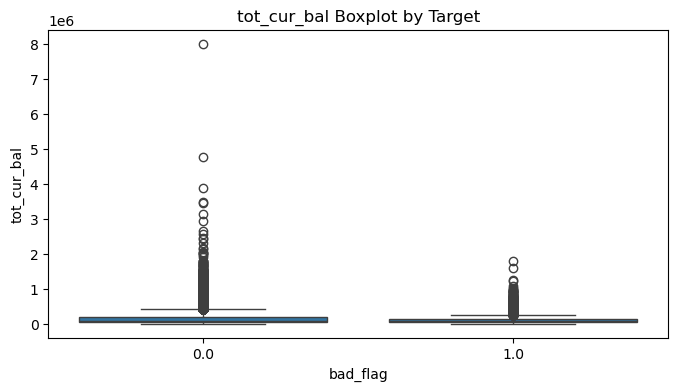

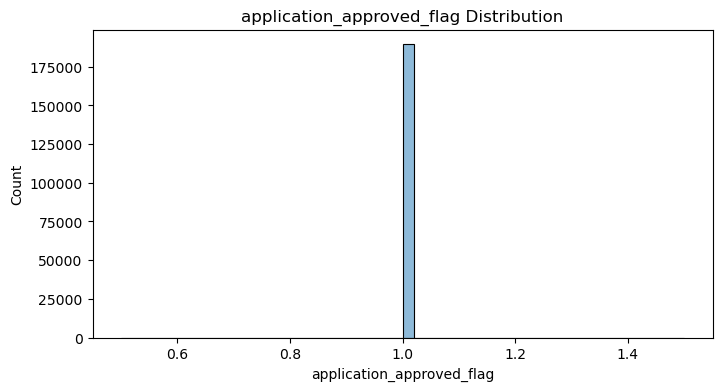

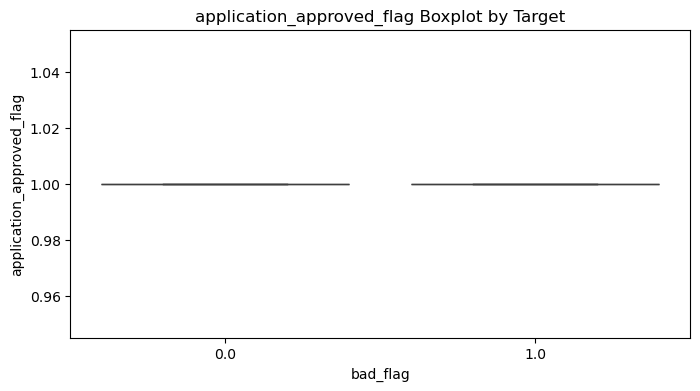

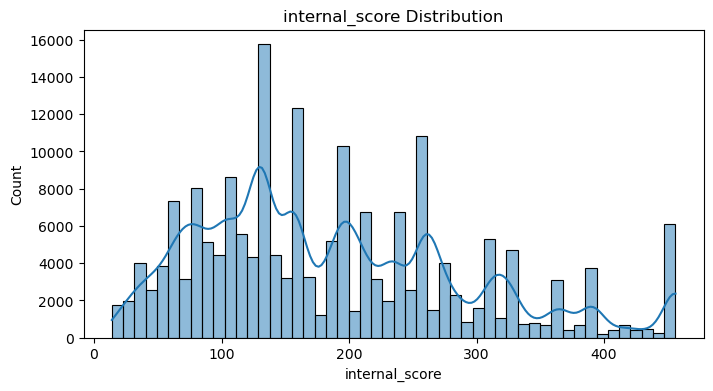

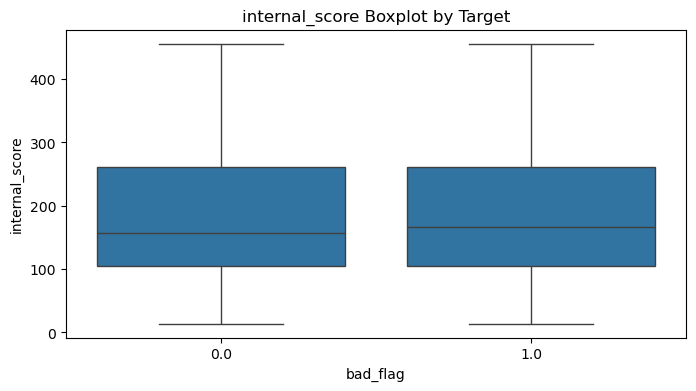

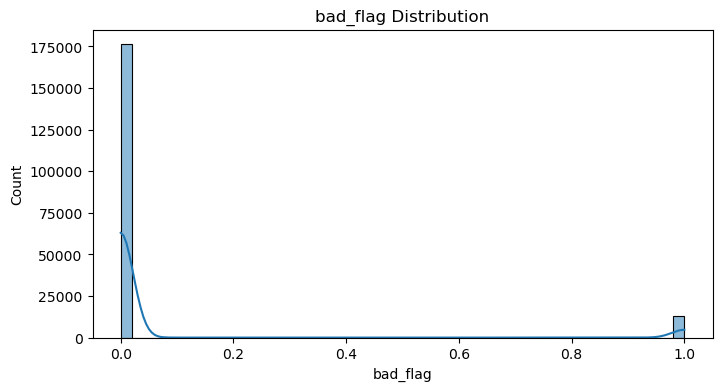

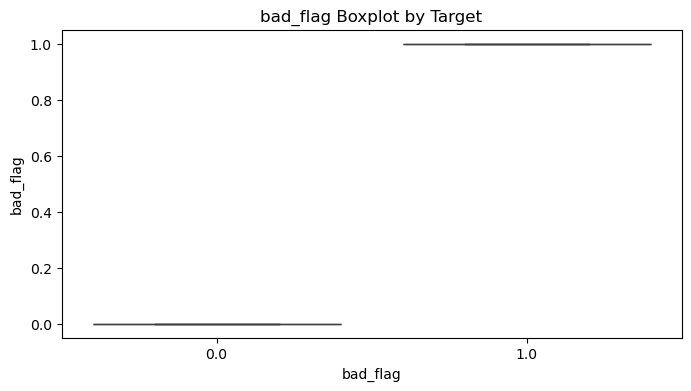

In [112]:
# Create a subplots for categorical column distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
categorical_cols = ['purpose', 'home_ownership', 'term', 'emp_length']
for i, col in enumerate(categorical_cols):
    row, col_idx = divmod(i, 2)
    sns.countplot(data=train_data, x=col, hue='bad_flag', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} Distribution with Target')
    for label in axes[row, col_idx].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

# Create a figure with 2x2 subplots for log-scaled distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, col in enumerate(categorical_cols):
    row, col_idx = divmod(i, 2)
    sns.countplot(data=train_data, x=col, hue='bad_flag', ax=axes[row, col_idx], palette='muted')
    axes[row, col_idx].set_yscale('log')
    axes[row, col_idx].set_title(f'{col} Distribution with Target (Log Scale)')
    for label in axes[row, col_idx].get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[col], kde=True, bins=50)
    plt.title(f'{col} Distribution')
    plt.show()
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=train_data, x='bad_flag', y=col)
    plt.title(f'{col} Boxplot by Target')
    plt.show()  